<a href="https://colab.research.google.com/github/danielbehargithub/LinkedIn_Salary/blob/main/Wage_and_Similarity_backup123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install all dependencies
!pip install gensim
!pip install nltk
!pip install pandas
!pip install numpy
!pip install requests
!pip install playwright
!playwright install
!pip install pycountry

In [ ]:
# Import libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument,Word2Vec
from nltk.tokenize import word_tokenize
from numpy.linalg import norm
from termcolor import colored
import pandas as pd
import numpy as np
import requests
import re
import plotly.graph_objects as go
import nltk
nltk.download('all', download_dir='/usr/local/lib/nltk_data')
from nltk import pos_tag
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer, util
import pycountry
import lightgbm as lgb

In [47]:
from google.colab import files

# Upload profile data
print("Please upload the profile_data file")
uploaded_profile = files.upload()
profile_data_file = next(iter(uploaded_profile.keys()))

# Upload job details
print("\nPlease upload the job_details file")
uploaded_job = files.upload()
job_details_file = next(iter(uploaded_job.keys()))

# Upload full model
print("\nPlease upload the full_model.pkl file")
uploaded_full_model = files.upload()
full_model_file = next(iter(uploaded_full_model.keys()))


Please upload the profile_data file


Saving profile_data (6).txt to profile_data (6).txt

Please upload the job_details file


Saving job_details (6) (1).txt to job_details (6) (1).txt

Please upload the full_model.pkl file


Saving full_model.pkl to full_model (1).pkl


In [80]:
def extract_section(file_path, start_keyword, end_keyword):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    extracting = False
    extracted_text = []

    for line in lines:
        if start_keyword in line:
            extracting = True
        if extracting:
            extracted_text.append(line.strip())
        if end_keyword in line:
            break

    return "\n".join(extracted_text)

unique_skills_raw = extract_section(profile_data_file, "Unique skills:", "Unique skills:")

if unique_skills_raw.startswith("Unique skills:"):
    unique_skills = unique_skills_raw.replace("Unique skills:", "").strip()

# Convert skills to a formatted string
profile_skills = f"""['{unique_skills.replace(', ', "', '")}']"""



In [55]:
def extract_description(file_path, start_keyword, end_keyword=None):
    """
    Extract a specific section of text from a file based on start and optional end keywords.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    extracting = False
    extracted_text = []

    for line in lines:
        if start_keyword in line:
            extracting = True
        if extracting:
            extracted_text.append(line.rstrip())  # Keep formatting with spaces
        if end_keyword and end_keyword in line:
            break

    return "\n".join(extracted_text)


# Extract the description section
job_description = extract_description(job_details_file, "Description  :")



In [57]:
# Extended stopwords for job descriptions
stop_words = set(stopwords.words('english')).union({
    'have', 'has', 'you', 'we', 'they', 'our', 'your', 'the', 'a', 'an', 'in', 'on', 'at', 'for', 'with', 'to', 'of',
    'and', 'or', 'is', 'are', 'was', 'were', 'be', 'will', 'can', 'should', 'would', 'could', 'may', 'might',
    'solid', 'relevant', 'extensive', 'proven', 'experience', 'possess', 'ability', 'skills', 'capabilities',
    'demonstrated', 'strong', 'knowledge', 'understanding', 'background', 'proficiency', 'required',
    'responsibilities', 'qualifications', 'advantage', 'must', 'preferred', 'environment', 'excellent', 'good',
    'key', 'various', 'well', 'including', 'new', 'opportunities', 'job', 'role', 'position'
})

# 1. Preprocessing Functions
def preprocess_text(text):
    """
    Preprocess text by removing excessive newlines, extra spaces, and special characters.
    """
    if not isinstance(text, str) or not text.strip():
        return ""
    text = re.sub(r'\s*\n\s*', ' ', text)  # Replace newlines with spaces
    text = re.sub(r'\s+', ' ', text)       # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)    # Remove special characters
    return text.strip().lower()            # Lowercase and strip whitespace

def extract_relevant_phrases(sentence):
    """
    Extract relevant phrases from a sentence by removing unnecessary words and focusing on key phrases.
    """
    # Remove unnecessary phrases using regex
    cleaned_sentence = re.sub(r'\b(have|has|possess|proven|solid|relevant|extensive|demonstrated|strong)\b', '', sentence, flags=re.IGNORECASE)
    cleaned_sentence = re.sub(r'\b(experience (in|with|on|of|for))\b', '', cleaned_sentence, flags=re.IGNORECASE)
    cleaned_sentence = re.sub(r'\b(ability to|proficiency in|knowledge of|understanding of|background in)\b', '', cleaned_sentence, flags=re.IGNORECASE)

    # Tokenize and remove stopwords
    tokens = word_tokenize(cleaned_sentence.lower())
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]

    # Extract nouns using POS tagging
    pos_tags = pos_tag(tokens)
    relevant_phrases = [word for word, tag in pos_tags if tag.startswith('NN')]  # Keep only nouns

    return ' '.join(relevant_phrases)

def process_job_description(description):
    """
    Process job description to split into sentences and extract relevant parts.
    """
    # Split the description into sentences using punctuation or bullet points
    sentences = re.split(r'[.\n•;]', description)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]  # Remove empty strings

    # Further split sentences into manageable phrases if too long
    processed_sentences = []
    for sentence in sentences:
        # Split sentences longer than a threshold into smaller parts by words
        if len(sentence.split()) > 20:  # Threshold: 20 words
            chunks = re.split(r'(?:,| and | or )', sentence)  # Split by commas, "and", or "or"
            processed_sentences.extend([chunk.strip() for chunk in chunks if chunk.strip()])
        else:
            processed_sentences.append(sentence)

    # Extract relevant phrases from each chunk
    processed_chunks = [extract_relevant_phrases(preprocess_text(chunk)) for chunk in processed_sentences]

    # Remove empty results
    return [chunk for chunk in processed_chunks if chunk]

# 2. Main Workflow
def compute_similarity(job_description, profile_skills, model, threshold=0.7):
    """
    Compute similarity between job description and profile skills using embeddings.
    """
    # Preprocess inputs
    job_skills_processed = process_job_description(preprocess_text(job_description))
    profile_skills_list = [preprocess_text(skill) for skill in eval(profile_skills)]  # Convert and preprocess profile skills

    # Encode skills using Sentence-BERT
    job_embeddings = model.encode(job_skills_processed, convert_to_tensor=True)
    profile_embeddings = model.encode(profile_skills_list, convert_to_tensor=True)

    # Compute cosine similarities
    cosine_similarities = util.pytorch_cos_sim(job_embeddings, profile_embeddings)

    # Adjust similarities based on threshold
    adjusted_similarities = []
    improvement_list=[]
    improvement_score=0.5
    total_similarity = 0
    comparison_count = 0

    for i in range(len(job_skills_processed)):
        similarity_row = cosine_similarities[i].tolist()
        max_similarity = max(similarity_row)
        # if max_similarity > threshold:
        #     similarity_row = [1.0] * len(similarity_row)
        if max_similarity <= improvement_score:
            improvement_list.append(job_skills_processed[i])
        adjusted_similarities.append(similarity_row)
        total_similarity += sum(similarity_row)
        comparison_count += len(similarity_row)

    # Calculate overall similarity
    overall_similarity = min(total_similarity / comparison_count , 1.0) if comparison_count > 0 else 0

    return adjusted_similarities, overall_similarity, job_skills_processed, profile_skills_list, improvement_list


In [58]:

#model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('bert-base-nli-mean-tokens')
#model = SentenceTransformer('all-roberta-large-v1')



# Compute similarities
adjusted_similarities, overall_similarity, job_skills_processed, profile_skills_processed,improvement_list = compute_similarity(
    job_description, profile_skills, model
)

# Display results
print("Adjusted Similarities:")
for i, job_skill in enumerate(job_skills_processed):
    for j, profile_skill in enumerate(profile_skills_processed):
        similarity_score = adjusted_similarities[i][j]
        print(f"Similarity between job skill '{job_skill}' and profile skill '{profile_skill}': {similarity_score:.2f}")



Adjusted Similarities:
Similarity between job skill 'description lsports provider sports data industry solutions sports data collection' and profile skill 'apache spark': 0.33
Similarity between job skill 'description lsports provider sports data industry solutions sports data collection' and profile skill 'data analysis': 0.47
Similarity between job skill 'description lsports provider sports data industry solutions sports data collection' and profile skill 'data structures': 0.41
Similarity between job skill 'description lsports provider sports data industry solutions sports data collection' and profile skill 'deep learning': 0.28
Similarity between job skill 'description lsports provider sports data industry solutions sports data collection' and profile skill 'django': 0.19
Similarity between job skill 'description lsports provider sports data industry solutions sports data collection' and profile skill 'html': 0.29
Similarity between job skill 'description lsports provider sports da

In [61]:
print(f"\nOverall Similarity: {overall_similarity:.2f}")


Overall Similarity: 0.47


In [ ]:
# Assume similarity is your final score as a percentage
similarity = overall_similarity * 100  # Convert to percentage if in range [0, 1]


In [62]:

# Visualization
fig = go.Figure(go.Indicator(
    domain={'x': [0, 1], 'y': [0, 1]},
    value=similarity,
    mode="gauge+number",
    title={'text': "Matching percentage (%)"},
    gauge={
        'axis': {'range': [0, 100]},
        'steps': [
            {'range': [0, 50], 'color': "#FFB6C1"},  # Light pink for low match
            {'range': [50, 70], 'color': "#FFFFE0"},  # Light yellow for moderate match
            {'range': [70, 100], 'color': "#90EE90"}  # Light green for high match
        ],
        'threshold': {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': similarity}  # Mark the current similarity
    }
))

fig.update_layout(width=600, height=400)  # Adjust the width and height as desired
fig.show()
print("Skills you might want to improve to increase your odds of getting the job:")
print(improvement_list)


Skills you might want to improve to increase your odds of getting the job:
['description lsports provider sports data industry solutions sports data collection', 'cuttingedge services sports tips', 'highquality sports visualization sports data industry lsports solutions share passion sports', 'drive advance sportstech', 'data industries join team share sports', 'sportstech', 'work ci git docker etl tools glueapache airflowprefect snowflakedatabricksbigquery']


In [329]:
import requests
import io
# Define the base URL and the download path
base_url = "https://aijobs.net"
download_path = "/salaries/download/salaries.csv"

# Construct the full URL for the CSV file
download_url = base_url + download_path

# Send a GET request to download the file
response = requests.get(download_url, allow_redirects=True)

# Check if the request was successful
if response.status_code == 200:
    print("File downloaded successfully. Loading into DataFrame...")

    # Read the CSV file directly into a pandas DataFrame from the response content
    data = pd.read_csv(io.StringIO(response.text))


File downloaded successfully. Loading into DataFrame...


In [330]:
data = data.drop(columns=["salary", "salary_currency", "employment_type", "salary_in_usd"])

categorical_columns = [
    'experience_level', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio'
]

# Convert categorical columns to categorical dtype
for col in categorical_columns:
    data[col] = data[col].astype('category')
# Print the number of unique values for each categorical column
print("\n🔹 Unique value count per categorical column:\n")
for col in categorical_columns:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")



🔹 Unique value count per categorical column:

experience_level: 4 unique values
employee_residence: 95 unique values
company_location: 89 unique values
company_size: 3 unique values
job_title: 300 unique values
remote_ratio: 3 unique values


In [331]:
data.head(5)

,work_year,experience_level,job_title,employee_residence,remote_ratio,company_location,company_size
0,2025,EN,Research Assistant,GB,50,GB,L
1,2025,SE,Data Scientist,US,0,US,M
2,2025,SE,Data Scientist,US,0,US,M
3,2025,SE,Research Engineer,US,0,US,M
4,2025,SE,Research Engineer,US,0,US,M


In [289]:
def categorize_experience(profile_text):
    """
    Function that maps an experience category (EN, MI, SE, EX) based on years of experience extracted from the text.
    :param profile_text: User profile text (string)
    :return: Experience category (string)
    """

    # Searching for years of experience in the text (e.g., '2 yrs', '10 years', '1 yr')
    experience_matches = re.findall(r"(\d+)\s*(?:yrs?|years?)", profile_text)

    # Converting the extracted years of experience to numbers
    years_of_experience = sum(map(int, experience_matches)) if experience_matches else 0

    # Categorizing experience based on the number of years
    if years_of_experience < 2:
        return 'EN'  # Entry Level
    elif 2 <= years_of_experience < 5:
        return 'MI'  # Mid Level
    elif 5 <= years_of_experience < 10:
        return 'SE'  # Senior Level
    else:
        return 'EX'  # Executive Level

# Read the uploaded file correctly
with open(profile_data_file, 'r', encoding='utf-8') as file:
    profile_data_text = file.read()


In [290]:
def extract_job_details_with_iso(job_text):
    """
    Extract job details from a given text and convert the company's location to an ISO 3166 Country Code using pycountry.
    :param job_text: Text containing job details
    :return: Dictionary with job details, including the ISO Country Code
    """

    # Extracting job title
    job_title = re.search(r"Job Title\s*:\s*(.+)", job_text)
    job_title = job_title.group(1).strip() if job_title else "N/A"

    # Extracting company name
    company_name = re.search(r"Company\s*:\s*(.+)", job_text)
    company_name = company_name.group(1).strip() if company_name else "N/A"

    # Extracting company location
    company_location = re.search(r"Location\s*:\s*(.+)", job_text)
    company_location = company_location.group(1).strip() if company_location else "N/A"



    # Converting company location to ISO 3166 Country Code
    country_code = "N/A"
    for country in pycountry.countries:
        if country.name in company_location:
            country_code = country.alpha_2
            break


    # Converting company location to ISO 3166 Country Code
    employee_residence = "N/A"
    for country in pycountry.countries:
        if country.name in employee_residence:
            country_code = country.alpha_2
            break

    # Determining remote work ratio based on conditions
    if "Remote" in job_text:
        remote_ratio = 100
    elif "Hybrid" in job_text:
        remote_ratio = 50
    elif "On-site" in job_text:
        remote_ratio = 0
    else:
        remote_ratio = "N/A"

    # Constructing the result
    return {
        "job_title": job_title,
        "company_name": company_name,
        "company_location": company_location,
        "iso_country_code": country_code,
        "remote_ratio": remote_ratio,
        "company_size": "N/A"  # Can be defined based on additional information
    }

with open(job_details_file, 'r', encoding='utf-8') as file:
    job_details_text = file.read()



In [332]:
# Function to extract unique values dynamically
def get_unique_values(column_name, dataset):
    """ Extract unique values from a given column in the dataset. """
    if column_name in dataset.columns:
        unique_vals = sorted(dataset[column_name].dropna().unique().astype(str))  # Convert to string and sort
        return unique_vals

# Example for updating the possible values dictionary
possible_values = {
    "experience_level": get_unique_values("experience_level", data),
    "remote_ratio": get_unique_values("remote_ratio", data),
    "company_location": get_unique_values("company_location", data),
    "company_size": get_unique_values("company_size", data),
    "job_title": get_unique_values("job_title", data),
    "work_year": get_unique_values("work_year", data),
    "employee_residence": get_unique_values("employee_residence", data),
}


In [334]:
experience_category = categorize_experience(profile_data_text)
job_details = extract_job_details_with_iso(job_details_text)
job_details["experience_level"] = experience_category
job_details["work_year"] = '2025'

if "iso_country_code" in job_details:
    job_details["employee_residence"] = job_details["iso_country_code"]
    job_details["company_location"] = job_details["iso_country_code"]

if job_details['remote_ratio'] == 'N/A':
    job_details['remote_ratio'] = '100'

if job_details['company_size'] == 'N/A':
    job_details['company_size'] = 'L'


In [335]:
job_details

{'job_title': 'Data Engineer',
 'company_name': 'LSports',
 'company_location': 'IL',
 'iso_country_code': 'IL',
 'remote_ratio': '100',
 'company_size': 'L',
 'experience_level': 'SE',
 'work_year': '2025',
 'employee_residence': 'IL'}

In [336]:
import ipywidgets as widgets
from IPython.display import display

# Store widgets for user interaction
user_inputs = {}

# Function to validate input
def validate_inputs():
    for key, value in user_inputs.items():
        if value.value == "N/A":
            print(f"Warning: The value for {key} is still N/A. Please choose a valid option.")
            return False
    return True

# Create dropdown menus ensuring full display of feature names
for key, value in job_details.items():
    if key in possible_values and possible_values[key]:  # Only if options exist
        value_str = str(value)  # Make sure the value is stored as a string
        user_inputs[key] = widgets.Dropdown(
            options= possible_values[key],  # Add N/A as a first option
            value=value_str if value_str in possible_values[key] else "N/A",  # Set default to N/A
            description=key.replace('_', ' ').title(),
            layout=widgets.Layout(width="350px"),
            style={'description_width': 'initial'},
            disabled=False
        )
        display(user_inputs[key])

# Button to confirm selection
submit_button = widgets.Button(description="Submit", layout=widgets.Layout(width="150px"))

def update_job_details(b):
    global submit_button

    # Check if inputs are valid
    if not validate_inputs():
        return

    # Update job details with selected values
    for key, widget in user_inputs.items():
        job_details[key] = widget.value
        widget.disabled = True  # Disable dropdown after submission

    submit_button.disabled = True  # Disable submit button

    print("\n✅ Updated Job Details:")
    for key, value in job_details.items():
        print(f"{key.replace('_', ' ').title()}: {value}")

submit_button.on_click(update_job_details)
display(submit_button)


Dropdown(description='Job Title', index=99, layout=Layout(width='350px'), options=('AI Architect', 'AI Data En…

Dropdown(description='Company Location', index=42, layout=Layout(width='350px'), options=('AD', 'AE', 'AM', 'A…

Dropdown(description='Remote Ratio', index=1, layout=Layout(width='350px'), options=('0', '100', '50'), style=…

Dropdown(description='Company Size', layout=Layout(width='350px'), options=('L', 'M', 'S'), style=DescriptionS…

Dropdown(description='Experience Level', index=3, layout=Layout(width='350px'), options=('EN', 'EX', 'MI', 'SE…

Dropdown(description='Work Year', index=5, layout=Layout(width='350px'), options=('2020', '2021', '2022', '202…

Dropdown(description='Employee Residence', index=42, layout=Layout(width='350px'), options=('AD', 'AE', 'AM', …

Button(description='Submit', layout=Layout(width='150px'), style=ButtonStyle())


✅ Updated Job Details:
Job Title: Data Engineer
Company Name: LSports
Company Location: IL
Iso Country Code: IL
Remote Ratio: 100
Company Size: L
Experience Level: SE
Work Year: 2025
Employee Residence: IL


In [196]:
import joblib
# loading model

full_model_dict = joblib.load(full_model_file)

# data extraction

quantile_models = full_model_dict["quantile_models"]
salary_spline = full_model_dict["salary_spline"]
train_columns = full_model_dict["train_columns"]
y_train = full_model_dict["y_train"]
predicted_salaries_train = full_model_dict["y_pred_train"]
y_test = full_model_dict["y_test"]
predicted_salaries_test = full_model_dict["y_pred_test"]
residual_errors_train = full_model_dict["residual_errors_train"]
quantile_predictions_train = full_model_dict["train_preds"]
quantile_predictions_test = full_model_dict["test_preds"]

print("All models and training results loaded successfully from 'full_model.pkl'.")

X_train_encoded = pd.DataFrame(columns=train_columns)  #


All models and training results loaded successfully from 'full_model.pkl'.


In [230]:
quantile_predictions_train

{0.2: array([ 96400. , 116539.5, 117000. , ..., 122129. ,  96328.5, 109385. ]),
 0.35: array([111843.7, 140152.6, 137140.3, ..., 138826.3, 114418.6, 127388.6]),
 0.5: array([129818., 160000., 160000., ..., 154030., 131385., 145875.]),
 0.6: array([141206., 170570., 175305., ..., 165570., 144040., 159625.]),
 0.7: array([156394., 186800., 193000., ..., 175500., 162000., 170950.]),
 0.85: array([190250., 217970., 227000., ..., 206070., 191640., 206000.]),
 0.92: array([213020., 245360., 258750., ..., 234020., 216820., 239030.])}

In [339]:
new_user = pd.DataFrame.from_dict({
    'experience_level': job_details["experience_level"],
    'company_location': job_details["company_location"],
    'job_title': job_details["job_title"],
    'remote_ratio': job_details["remote_ratio"],
    'company_size': job_details["company_size"],
    'employee_residence': job_details["employee_residence"],
    'work_year': job_details["work_year"]
}, orient="index").T

# Categorical columns
categorical_columns = [
    'experience_level', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio'
]

# Convert columns to categorical type
for col in categorical_columns:
    if col in new_user.columns:
        new_user[col] = new_user[col].astype('category')

# Ensure relevant columns match those in X_train
for col in categorical_columns:
    if col not in new_user.columns:
        # Add a categorical column with a default value 'Unknown'
        new_user[col] = "Unknown"
        new_user[col] = new_user[col].astype('category')



In [340]:
new_user

,experience_level,company_location,job_title,remote_ratio,company_size,employee_residence,work_year
0,SE,IL,Data Engineer,100,L,IL,2025


In [341]:
# נבצע One-Hot Encoding על הדאטה שלנו
data_encoded = pd.get_dummies(data, columns=categorical_columns)


In [362]:

# נבצע One-Hot Encoding על המשתמש שלנו
user_df = pd.DataFrame(new_user)

# נקרא את ה-Dummies של המשתמש
user_encoded = pd.get_dummies(user_df, columns=categorical_columns)

# נוודא שכל העמודות תואמות אחת לשנייה
user_encoded = user_encoded.reindex(columns=data_encoded.columns, fill_value=0)

user_encoded = user_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


In [355]:
# מציג את העמודות שבהן הערכים אינם אפס
non_zero_columns = user_encoded.columns[user_encoded.ne(0).any()]


In [356]:
non_zero_columns

Index(['work_year', 'experience_level_SE', 'employee_residence_IL',
       'company_location_IL', 'company_size_L', 'job_title_Data Engineer',
       'remote_ratio_100'],
      dtype='object')

In [363]:
user_encoded

,work_year,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,job_title_AI Architect,job_title_AI Data Engineer,job_title_AI Data Scientist,job_title_AI Developer,job_title_AI Engineer,...,company_location_UA,company_location_US,company_location_VE,company_location_VN,company_location_XK,company_location_ZA,company_location_ZM,company_size_L,company_size_M,company_size_S
0,2025,0,0,0,True,0,0,0,0,0,...,0,0,0,0,0,0,0,True,0,0


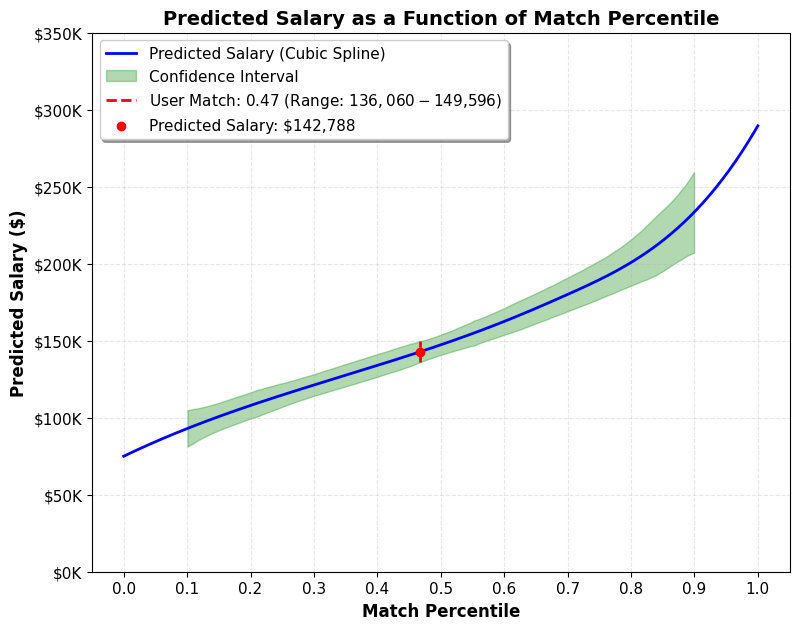

In [233]:
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Define the range of match percentiles
match_percentiles = np.linspace(0, 1, 200)

# 🔹 Predict salary for each percentile using the trained Spline model
predicted_salaries = salary_spline(match_percentiles)

# 🔹 Compute the user's match percentile and predicted salary
user_match_percentile = overall_similarity  # Dynamic value
predicted_salary = salary_spline(user_match_percentile)

# 🔹 Compute local standard deviation based on residual percentiles
sigma_percentiles = np.array([
    np.std(residual_errors_train[
        (residual_errors_train >= np.percentile(residual_errors_train, p * 100 - 5)) &
        (residual_errors_train <= np.percentile(residual_errors_train, p * 100 + 5))
    ]) if 5 < p * 100 < 95 else np.std(residual_errors_train)  # Handling edge cases
    for p in match_percentiles
])

# 🔹 Define the 95% confidence interval
salary_lower_bound = predicted_salaries - 1.96 * sigma_percentiles
salary_upper_bound = predicted_salaries + 1.96 * sigma_percentiles

# 🔹 Set the green confidence interval range based on the user's match percentile
if user_match_percentile > 0.8:
    lower_limit = 0.1
    upper_limit = min(user_match_percentile + 0.1, 1)
elif user_match_percentile < 0.2:
    lower_limit = max(user_match_percentile - 0.1, 0)
    upper_limit = 0.9
else:
    lower_limit = 0.1
    upper_limit = 0.9

valid_range = (match_percentiles >= lower_limit) & (match_percentiles <= upper_limit)

# 🔹 Compute a dynamic upper limit for the Y-axis
salary_max_dynamic = max(max(salary_upper_bound[valid_range]), max(predicted_salaries[valid_range])) + 50000

# 🔹 Create the plot
plt.figure(figsize=(9, 7))

# 🔹 Plot the predicted salary curve
plt.plot(match_percentiles, predicted_salaries, label="Predicted Salary (Cubic Spline)", color="blue", linewidth=2)

# 🔹 Plot the confidence interval only in relevant areas
plt.fill_between(match_percentiles[valid_range],
                 salary_lower_bound[valid_range],
                 salary_upper_bound[valid_range],
                 color="green", alpha=0.3, label="Confidence Interval")

# 🔹 Cut the red dashed line at the prediction range
user_idx = np.argmax(match_percentiles >= user_match_percentile)
plt.plot([user_match_percentile, user_match_percentile],
         [salary_lower_bound[user_idx], salary_upper_bound[user_idx]],
         color="red", linestyle="--", linewidth=2,
         label=f"User Match: {user_match_percentile:.2f} (Range: ${salary_lower_bound[user_idx]:,.0f} - ${salary_upper_bound[user_idx]:,.0f})")

# 🔹 Mark the user's predicted salary with a red dot
plt.scatter([user_match_percentile], [predicted_salary], color="red", zorder=3,
            label=f"Predicted Salary: ${predicted_salary:,.0f}")

# 🔹 Set X-axis ticks at 0.1 intervals
plt.xticks(np.arange(0, 1.1, 0.1), [f"{x:.1f}" for x in np.arange(0, 1.1, 0.1)], fontsize=11)

# 🔹 Set a dynamic Y-axis range
salary_min = 0
yticks = np.arange(salary_min, salary_max_dynamic + 50000, 50000)
plt.yticks(yticks, [f"${int(y/1000)}K" for y in yticks], fontsize=11)

# 🔹 Customize the plot
plt.xlabel("Match Percentile", fontsize=12, fontweight="bold")
plt.ylabel("Predicted Salary ($)", fontsize=12, fontweight="bold")
plt.title("Predicted Salary as a Function of Match Percentile", fontsize=14, fontweight="bold")
plt.legend(fontsize=11, loc="upper left", frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle="--")

# 🔹 Display the plot
plt.show()


In [369]:
from scipy.stats import percentileofscore


In [349]:
import numpy as np
from scipy.interpolate import CubicSpline

quantiles = list(quantile_models.keys())  # שואב את הקוונטילים מתוך המודל עצמו

def predict_salary(user_data, match_percentile):
    """
    חיזוי שכר מותאם אישית ליוזר לפי אחוזון התאמה ספציפי, תוך יצירת Spline דינמי עבורו.
    """
    # הפיכת הנתונים לטבלת DataFrame והמרה לפורמט מתאים

    # חיזוי שכר עבור אחוזון 50% (המדיאן)
    predicted_median = quantile_models[0.5].predict(user_data)[0]

    # הדפסת השכר החזוי
    print(f"Predicted Salary (Median): ${predicted_median:,.2f}")

    # חישוב טעות החיזוי עבור יוזר חדש (ההפרש בין חיזוי לשכר במדגם האימון)
    user_error = predicted_median - y_train.median()

    # חישוב אחוז ההתאמה לפי שגיאות במדגם האימון
    user_match_percentile = percentileofscore(residual_errors_train, user_error) / 100

    # הדפסת אחוזון התאמה
    print(f"User Match Percentile: {user_match_percentile:.2f}")
    # חיזוי סופי עם Spline מבוסס אחוזון התאמה
    final_predicted_salary = salary_spline(user_match_percentile)

    # הצגת התוצאה
    print(f"Final Adjusted Predicted Salary: ${final_predicted_salary:,.2f}")


In [377]:
predicted_salary = quantile_models[0.5].predict(user_encoded)[0]


In [378]:
predicted_salary

85647.0

In [381]:
predicted_salary_from_spline = salary_spline(0.5)


In [380]:
predicted_salary_from_spline

array(147340.45838635)

In [366]:
user_error = predicted_median - y_train.median()
user_error

-1056930.0

In [370]:
user_match_percentile = percentileofscore(residual_errors_train, user_error) / 100


In [373]:
user_match_percentile

0.0

In [371]:
final_predicted_salary = salary_spline(user_match_percentile)


In [372]:
final_predicted_salary

array(74998.1044804)